# active inference model of agency task (basic; conor's tutorial version)

### prerequisites

In [1]:
# !pip install inferactively-pymdp
import os
import sys
import pathlib
import numpy as np 
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import pymdp

from pymdp import utils 
from pymdp import maths
from pymdp.maths import softmax
from pymdp.agent import Agent

### specifying the states and observations

In [2]:
context_names = ['human_positive', 'human_negative', 
                 'comp_positive', 'comp_negative', 'zero']
choice_names = ['humanAction_compAction', 'humanAction_compNoAction', 
                'humanNoAction_compAction', 'humanNoAction_compNoAction']

""" Define `num_states` and `num_factors` below """
num_states = [len(context_names), len(choice_names)]
num_factors = len(num_states)

context_action_names = ['do_nothing']
choice_action_names = ['humanAction_compAction', 'humanAction_compNoAction',
                       'humanNoAction_compAction', 'humanNoAction_compNoAction']

""" Define `num_controls` below """
num_controls = [len(context_action_names), len(choice_action_names)]

outcome_obs_names = ['outcome_present', 'outcome_absent']
choice_obs_names = ['humanAction_compAction', 'humanAction_compNoAction',
                    'humanNoAction_compAction', 'humanNoAction_compNoAction']

""" Define `num_obs` and `num_modalities` below """
num_obs = [len(outcome_obs_names), len(choice_obs_names)]
num_modalities = len(num_obs)

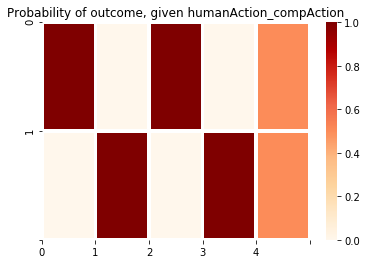

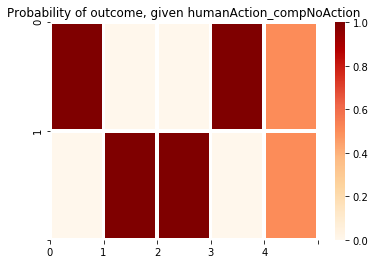

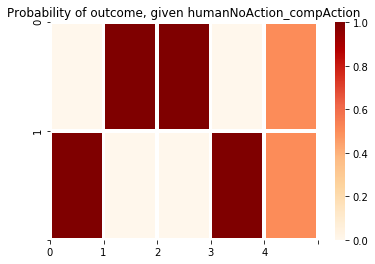

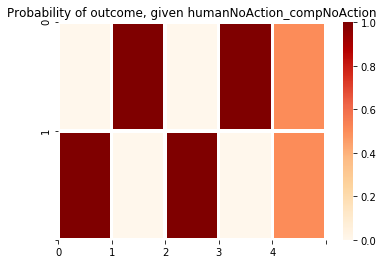

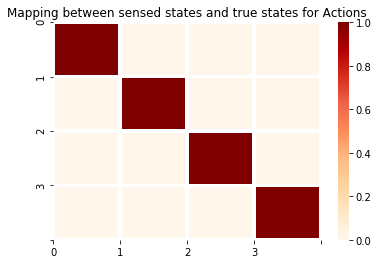

In [3]:
def create_A(p_outcome=1.0):
    
    A = utils.initialize_empty_A(num_obs, num_states)
    
    '''likelihood matrix for outcome modality'''
    
    p_outcome = 1.0 # probability of outcome occurring, according to the agent's generative model
    
    A_outcome = np.zeros( (len(outcome_obs_names), len(context_names), len(choice_names)) )
    
    for choice_id, choice_name in enumerate(choice_names):
        
        if choice_name == "humanAction_compAction":
            A_outcome[:,:,choice_id] = [[p_outcome, 1-p_outcome, p_outcome, 1-p_outcome, .5], 
                                        [1-p_outcome, p_outcome, 1-p_outcome, p_outcome, .5]]
        elif choice_name == "humanAction_compNoAction":
            A_outcome[:,:,choice_id] = [[p_outcome, 1-p_outcome, 1-p_outcome, p_outcome, .5],
                                        [1-p_outcome, p_outcome, p_outcome, 1-p_outcome, .5]]
        elif choice_name == "humanNoAction_compAction":
            A_outcome[:,:,choice_id] = [[1-p_outcome, p_outcome, p_outcome, 1-p_outcome, .5],
                                        [p_outcome, 1-p_outcome, 1-p_outcome, p_outcome, .5]]
        elif choice_name == "humanNoAction_compNoAction":
            A_outcome[:,:,choice_id] = [[1-p_outcome, p_outcome, 1-p_outcome, p_outcome, .5],
                                        [p_outcome, 1-p_outcome, p_outcome, 1-p_outcome, .5]]
    
    '''likelihood matrix for proprioception modality'''        
    A_choice = np.zeros((len(choice_obs_names), len(context_names), len(choice_names)))
    
    for choice_id in range(len(choice_names)):
        A_choice[choice_id, :, choice_id] = 1.0
        
    A[0], A[1] = A_outcome, A_choice
    
    return A

A = create_A(p_outcome=1.0)

utils.plot_likelihood(A[0][:,:,0], title = "Probability of outcome, given humanAction_compAction")
utils.plot_likelihood(A[0][:,:,1], title = "Probability of outcome, given humanAction_compNoAction")
utils.plot_likelihood(A[0][:,:,2], title = "Probability of outcome, given humanNoAction_compAction")
utils.plot_likelihood(A[0][:,:,3], title = "Probability of outcome, given humanNoAction_compNoAction")
utils.plot_likelihood(A[1][:,0,:], title="Mapping between sensed states and true states for Actions")

In [4]:
def create_B(p_change=0.0):
    # `p_change`: probability of the context changing
    B = utils.initialize_empty_B(num_states, num_states)
    
    B_context = np.zeros( (len(context_names), len(context_names), len(context_action_names)) )
    B_context[:,:,0] = np.eye(len(context_names))
    
    B_choice = np.zeros( (len(choice_names), len(choice_names), len(choice_action_names)) )
    
    for choice_id in range(len(choice_names)):
        B_choice[choice_id, :, choice_id] = 1.0
        
    B[0], B[1] = B_context, B_choice
    
    return B

B = create_B(p_change=0.0)

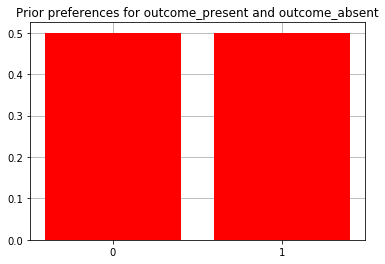

In [5]:
def create_C(reward=0.0, pun=0.0):
    
    # define reward and punishment values mapping onto outcome_present and outcome_absent preferences
    
    C = utils.obj_array_zeros(num_obs)
    C[0] = np.array([reward, pun])
    
    return C

C = create_C(reward=0.0, pun=0.0)

utils.plot_beliefs(softmax(C[0]), title = "Prior preferences for outcome_present and outcome_absent")

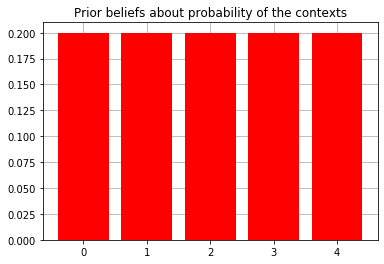

In [6]:
def create_D(p_context=1/float(num_states[0])):
    
    D = utils.obj_array(num_factors)
    
    D_context = np.ones(num_states[0])/float(num_states[0])
    D[0] = D_context 
    
    D_choice = np.ones(num_states[1])/float(num_states[1])
    D[1] = D_choice
    
    return D

D = create_D()

utils.plot_beliefs(softmax(D[0]), title = "Prior beliefs about probability of the contexts")

In [7]:
class AgencyTask(object):
    
    def __init__(self, context = None, p_outcome=1.0):
        
        self.context_names = ['human_positive', 'human_negative',
                              'comp_positive', 'comp_negative', 'zero']
        if context == None:
            self.context = self.context_names[utils.sample(np.ones(num_states[0])/float(num_states[0]))] # randomly sample which context is selected
        else:
            self.context = context
            
        self.p_outcome = p_outcome
        self.outcome_obs_names = ['outcome_present', 'outcome_absent']
        
        
    def step(self, action):
        if action == "humanAction_compAction":
            if self.context == "human_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
                observed_choice = "humanAction_compAction"
            elif self.context == "human_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                observed_choice = "humanAction_compAction"
            elif self.context == "comp_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
                observed_choice = "humanAction_compAction"
            elif self.context == "comp_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                observed_choice = "humanAction_compAction"
        elif action == "humanAction_compNoAction":
            if self.context == "human_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
                observed_choice = "humanAction_compNoAction"
            elif self.context == "human_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                observed_choice = "humanAction_compNoAction"
            elif self.context == "comp_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                observed_choice = "humanAction_compNoAction"
            elif self.context == "comp_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
                observed_choice = "humanAction_compNoAction"
        elif action == "humanNoAction_compAction":
            if self.context == "human_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                observed_choice = "humanNoAction_compAction"
            elif self.context == "human_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
                observed_choice = "humanNoAction_compAction"
            elif self.context == "comp_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
                observed_choice = "humanNoAction_compAction"
            elif self.context == "comp_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                observed_choice = "humanNoAction_compAction"
        elif action == "humanNoAction_compNoAction":
            if self.context == "human_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                observed_choice = "humanNoAction_compNoAction"
            elif self.context == "human_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
                observed_choice = "humanNoAction_compNoAction"
            elif self.context == "comp_positive":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                observed_choice = "humanNoAction_compNoAction"
            elif self.context == "comp_negative":
                observed_outcome = self.outcome_obs_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
                observed_choice = "humanNoAction_compNoAction"

        obs = [observed_outcome, observed_choice]

        return obs
        
  

In [12]:
def run_active_inference_loop(my_agent, my_env, T = 15, verbose = False):
    
    """ Initialize the first observation """
    obs_label = ["outcome_present", "humanAction_compAction"]  
    obs = [outcome_obs_names.index(obs_label[0]), choice_obs_names.index(obs_label[1])]
    
    first_choice = choice_obs_names.index(obs_label[1])
    choice_hist = np.zeros((4,T+1))
    choice_hist[first_choice,0] = 1.0
    
    belief_hist = np.zeros((5, T))
    context_hist = np.zeros(T)
    
    for t in range(T):
        context_hist[t] = env.context_names.index(env.context)
        qs = my_agent.infer_states(obs)
        
        belief_hist[:,t] = qs[0]
        
        if verbose:
            utils.plot_beliefs(qs[0], title = f"Beliefs about the context at time {t}")
            
        q_pi, efe = my_agent.infer_policies()
        chosen_action_id = my_agent.sample_action()
        
        movement_id = int(chosen_action_id[1])
        choice_hist[movement_id,t+1]= 1.0
        
        choice_action = choice_action_names[movement_id]
        
        obs_label = my_env.step(choice_action)
        
        obs = [outcome_obs_names.index(obs_label[0]), choice_obs_names.index(obs_label[1])]
        
        if verbose:
            print(f'Action at time {t}: {choice_action}')
            print(f'Outcome at time {t}: {obs_label[0]}')

    return choice_hist, belief_hist, context_hist

In [13]:
def plot_choices_beliefs(choice_hist, belief_hist, context_hist, pad_val=5.0):
    T = choice_hist.shape[1]
    fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (15,13))
    axes[0].imshow(choice_hist[:,:-1], cmap = 'gray') 
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(4))
    axes[0].set_yticklabels(labels = choice_action_names)
    axes[0].set_title('Choices over time')
    
    axes[1].imshow(belief_hist, cmap = 'gray')
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(5))
    axes[1].set_yticklabels(labels = ['human_positive', 'human_negative', 'comp_positive', 'comp_negative', 'zero'])
    axes[1].set_title('Beliefs over time')
    axes[1].scatter(np.arange(T-1), context_hist, c = 'r', s = 50)
    
    fig.tight_layout(pad=pad_val)
    plt.show()

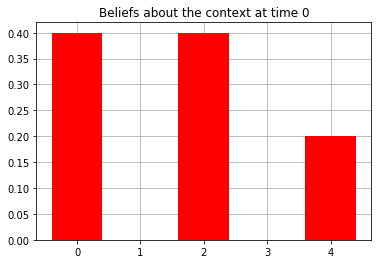

Action at time 0: humanAction_compNoAction
Outcome at time 0: outcome_absent


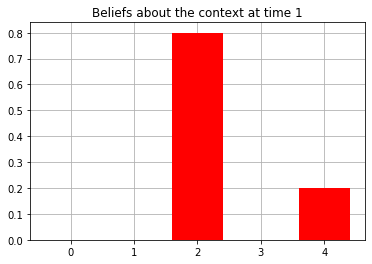

Action at time 1: humanAction_compAction
Outcome at time 1: outcome_present


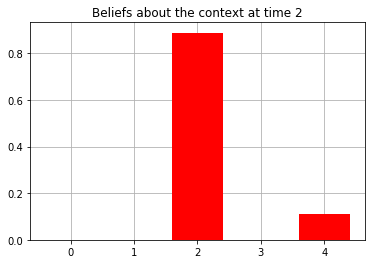

Action at time 2: humanAction_compAction
Outcome at time 2: outcome_present


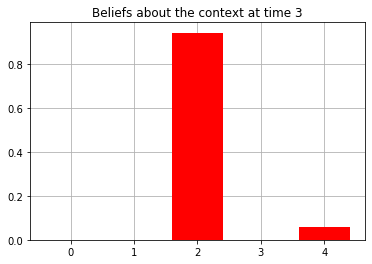

Action at time 3: humanAction_compAction
Outcome at time 3: outcome_present


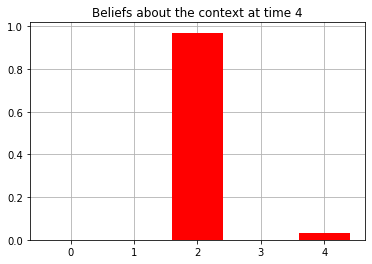

Action at time 4: humanAction_compAction
Outcome at time 4: outcome_present


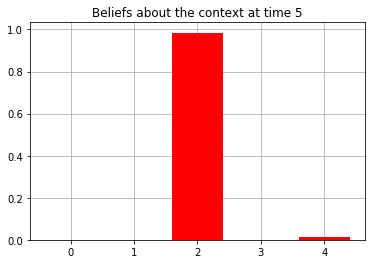

Action at time 5: humanAction_compAction
Outcome at time 5: outcome_present


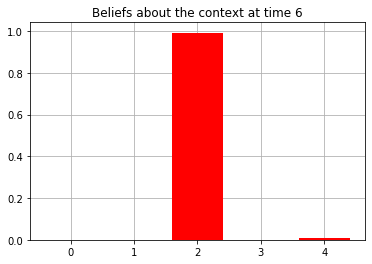

Action at time 6: humanAction_compAction
Outcome at time 6: outcome_present


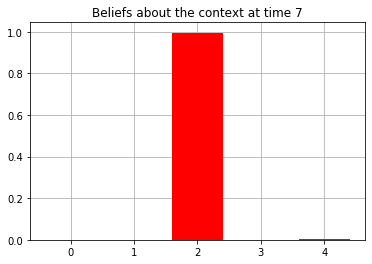

Action at time 7: humanAction_compAction
Outcome at time 7: outcome_present


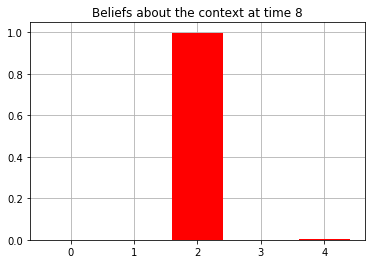

Action at time 8: humanAction_compAction
Outcome at time 8: outcome_present


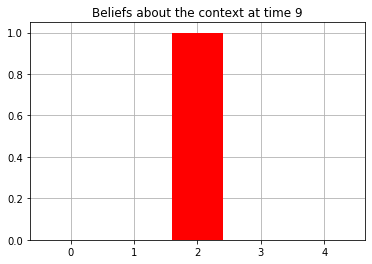

Action at time 9: humanAction_compAction
Outcome at time 9: outcome_present


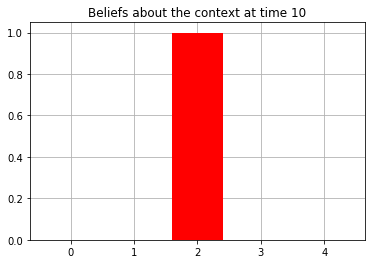

Action at time 10: humanAction_compAction
Outcome at time 10: outcome_present


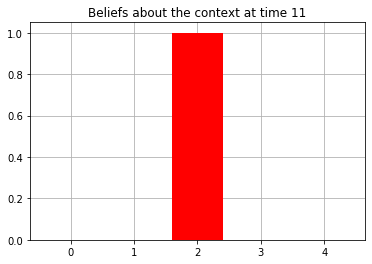

Action at time 11: humanAction_compAction
Outcome at time 11: outcome_present


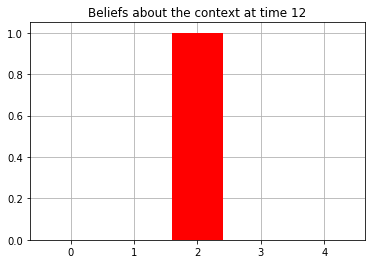

Action at time 12: humanAction_compAction
Outcome at time 12: outcome_present


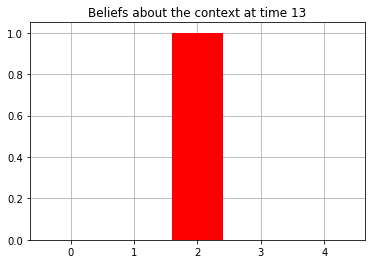

Action at time 13: humanAction_compAction
Outcome at time 13: outcome_present


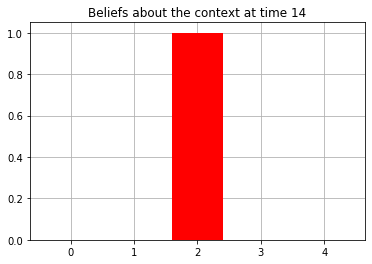

Action at time 14: humanAction_compAction
Outcome at time 14: outcome_present


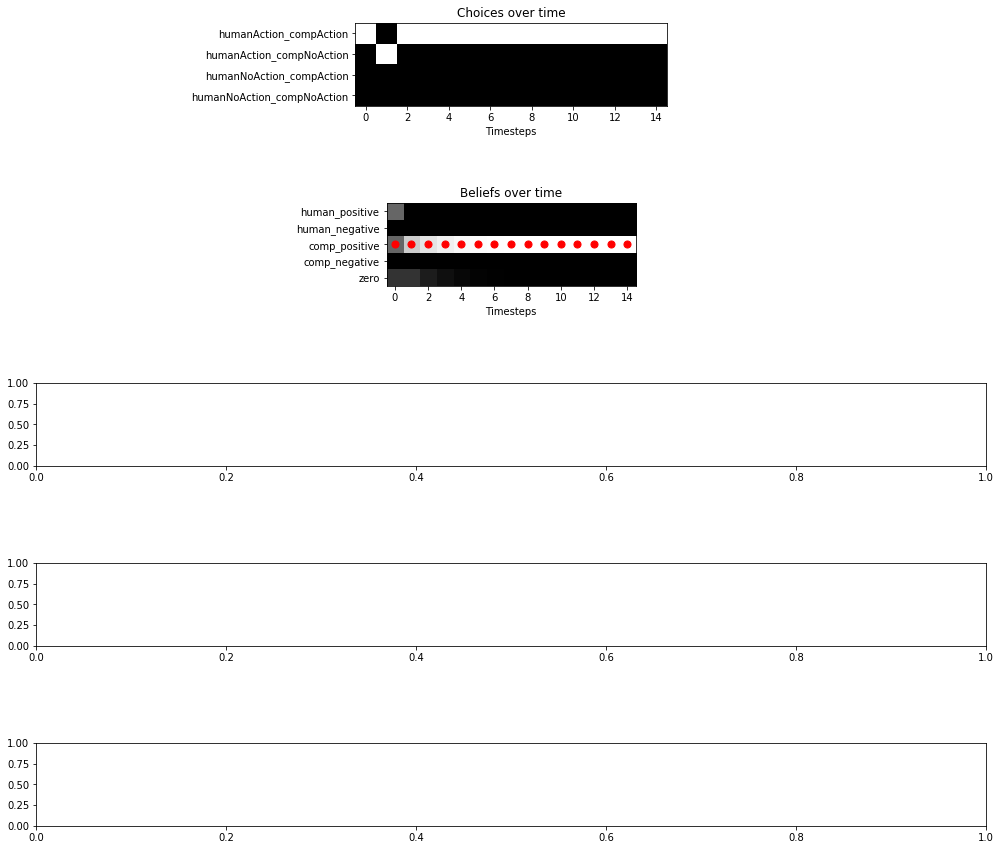

In [14]:
p_outcome_env = 1.0

env = AgencyTask(p_outcome=p_outcome_env)

T = 15

A = create_A(p_outcome=1.0)
B = create_B(p_change=0.0)
C = create_C(reward=0.0, pun=0.0)
D = create_D(p_context=1/float(num_states[0]))
my_agent = Agent(A=A, B=B, C=C, D=D)

choice_hist, belief_hist, context_hist = run_active_inference_loop(my_agent, env, T = T, verbose = True)
plot_choices_beliefs(choice_hist, belief_hist, context_hist)